In [1]:
from matplotlib.axes import Axes
from matplotlib.patches import Rectangle

from only_front.fuzzy.env_front_lidar_fuzzy import *
from only_front.fuzzy.visualiser import *
from pandas import *
import csv

pygame 2.1.3.dev8 (SDL 2.0.22, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from matplotlib import *
from matplotlib.pyplot import  *
%matplotlib inline

In [3]:
env_size=1000
unit=env_size/25

n=5
sensor_range=50
roboot_radius=0.5
DX, DY=desiredXYSquarePattern(n, roboot_radius+10)



env=Env(width=env_size, height=env_size, goal_x=23*unit, goal_y=unit*23,N=n*n,desired_X=DX, desired_Y=DY, sensor_range=sensor_range, leader_x=unit, leader_y=4*unit)
env.addObstacle(0, 0, env_size, 3*unit)
env.addObstacle(0, 5*unit, 5*unit, env_size)
env.addObstacle(7*unit, 5*unit, 11*unit, 10*unit)
env.addObstacle(13*unit, 5*unit, 17*unit, 17*unit)
env.addObstacle(20*unit, 5*unit, env_size, 11*unit)
env.addObstacle(7*unit, 12*unit, 11*unit, 17*unit)
env.addObstacle(21*unit, 12*unit, env_size, 17*unit)
env.addObstacle(7*unit, 20*unit, 20*unit, env_size)



In [4]:
# #test
# w=15
# v=10
# 
# episode_gui(env, v, w*pi/180, draw_way=True)

In [5]:
def episode(env: Env, v:float, w:float):
    env.reset()
    while(not env.is_done):
        env.play_step(v,w*pi/180)

In [6]:
def draw_episode(env:Env, ax:Axes):
    posei=env.pose_history[:, env.N, :]
    ax.plot(posei[:env.t-1,0], posei[:env.t-1, 1], linestyle='dashdot',  label='Virtual Leader', color='blue', zorder=3)
    line=[None]*env.N
    for i in range(env.N):
                    posei=env.pose_history[:, i, :]
                    deadi=env.dead_history[:, i]
                    posei=posei[~deadi]
                    ax.plot(posei[:,0], posei[:, 1], label='Agent '+str(i), color='aqua')
    for wall in env.walls:
                    ax.add_patch(Rectangle((wall.from_x, wall.from_y), wall.length_x, wall.length_y, color='black'))
    ax.scatter(env.xL0, env.yL0, marker='*', zorder=3, color='blue', s=150)
    ax.scatter(env.xG, env.yG, marker='*', zorder=3, color='blue', s=150)
    for agent in env.agents:
                    ax.scatter(env.xL0+agent.dx, env.yL0+agent.dy, color='limegreen')
                    ax.scatter(env.pose_history[env.t-1, agent.id, 0], env.pose_history[env.t-1, agent.id, 1], color='red' if agent.is_dead else 'limegreen')

In [7]:
W= numpy.array([1, 2, 3, 5, 10, 15, 20, 30])
V=numpy.array(range(1, 101))/10

In [8]:
dir_name='run'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

In [9]:
report_file_name=os.path.join(dir_name, 'report.csv')
names = ['row','v', 'w', 't', 'alive_agent_count']

if os.path.exists(report_file_name):
    df=pandas.read_csv(report_file_name, names=names, header=None,  dtype=float)
    df['row']=df['row'].astype(int)
    df_last=df.iloc[-1]
    w0i = int(numpy.where(W== df_last['w'])[0])
    v0i = int(numpy.where(V==df_last['v'])[0])+1

    run = int(df_last['row']+1)
    # df_.set_index(['row'], inplace=True)
else:
    w0i=0
    v0i=0
    run = 0
    df=pandas.DataFrame(columns=names)

In [10]:
df.head()

,row,v,w,t,alive_agent_count
0,0,0.1,1.0,14440.0,25.0
1,1,0.2,1.0,7193.0,20.0
2,2,0.3,1.0,4722.0,10.0
3,3,0.4,1.0,3594.0,20.0
4,4,0.5,1.0,2842.0,10.0


30


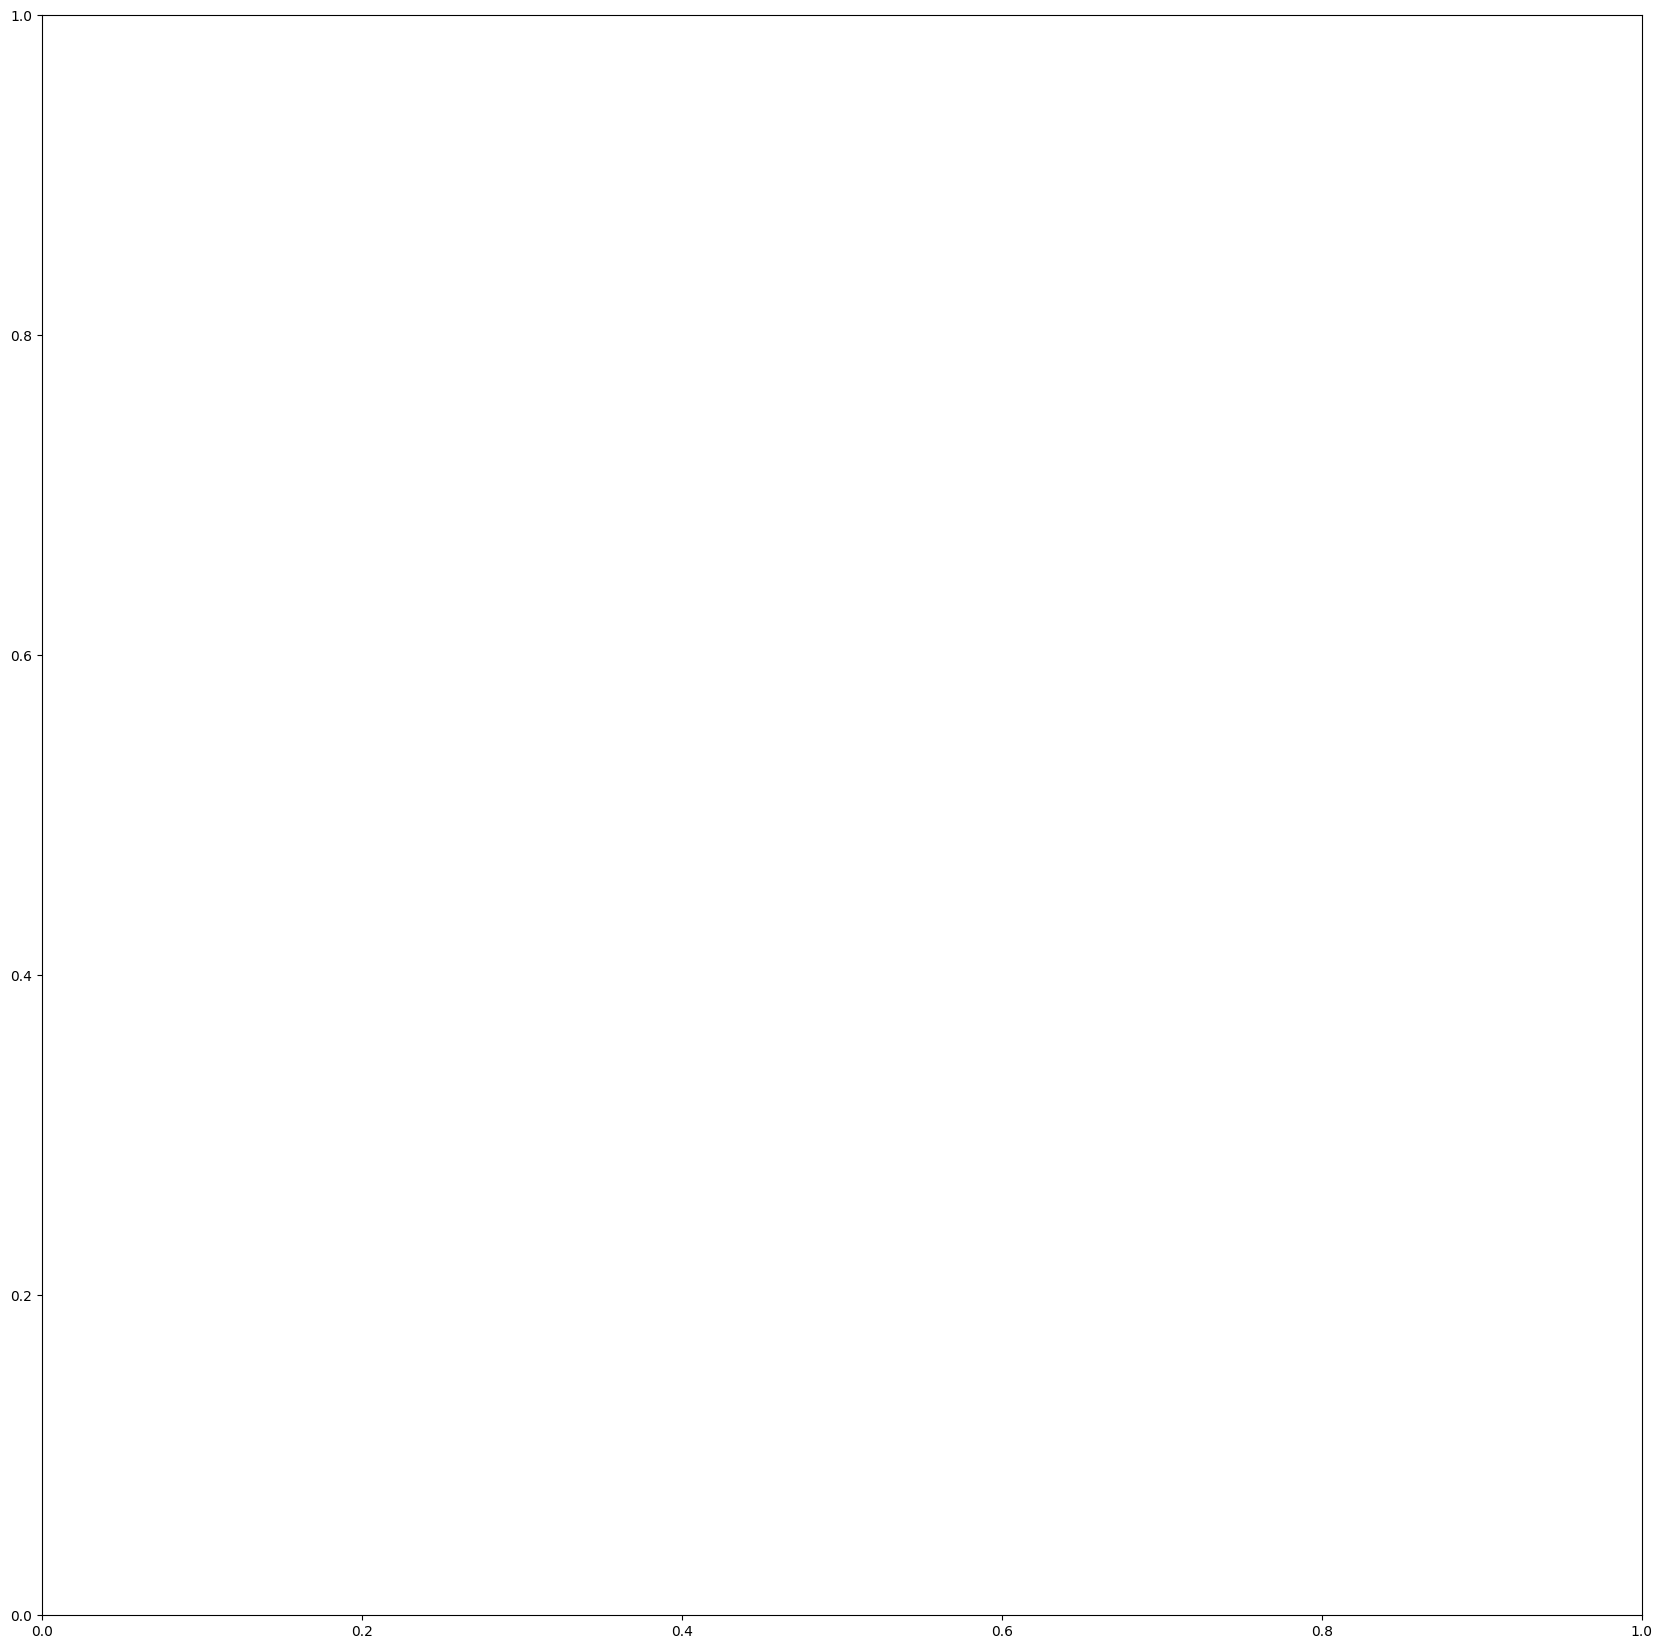

In [11]:
from matplotlib import pyplot

fig = pyplot.figure(figsize=(16, 16))
ax = fig.add_axes([0, 0, 1, 1])
for wi in range(w0i, W.size):
    w=W[wi]
    print(w)
    for vi in range(v0i,  V.size):
        v=V[vi]
        episode(env, v, w)

        ####################################################
        ax.invert_yaxis()
        draw_episode(env, ax=ax)
        fig.savefig(os.path.join(dir_name, 'run'+str(run)+'W'+str(w)+'V'+str(v)+'.jpg'), bbox_inches='tight')
        ax.clear()
        # fig.clf()
        # pyplot.clf()
        ##################################################

        env.save_episode(os.path.join(dir_name, 'run'+str(run)))
        alive_agent_count = n * n - numpy.sum(env.dead_history[env.t - 1, :])
        t = env.t if (equals(leader_goal_distance(env), 0, 10)) else None
        # print(t)
        # print(alive_agent_count)
        row=[run, v, w, t, alive_agent_count]
        df.loc[run]=row
        print(row)



        with open(report_file_name, 'a') as report_file:
            writer=csv.writer(report_file)
            writer.writerow(row)
        # numpy.savez(file_name, w=wi, run=run, v=vi)
        run+=1
    v0i=0
w0i=0

In [12]:
df_to_plot_t=df.pivot(index='v', columns='w', values='t')
df_to_plot_s=df.pivot(index='v', columns='w', values='alive_agent_count')

<AxesSubplot: xlabel='v'>

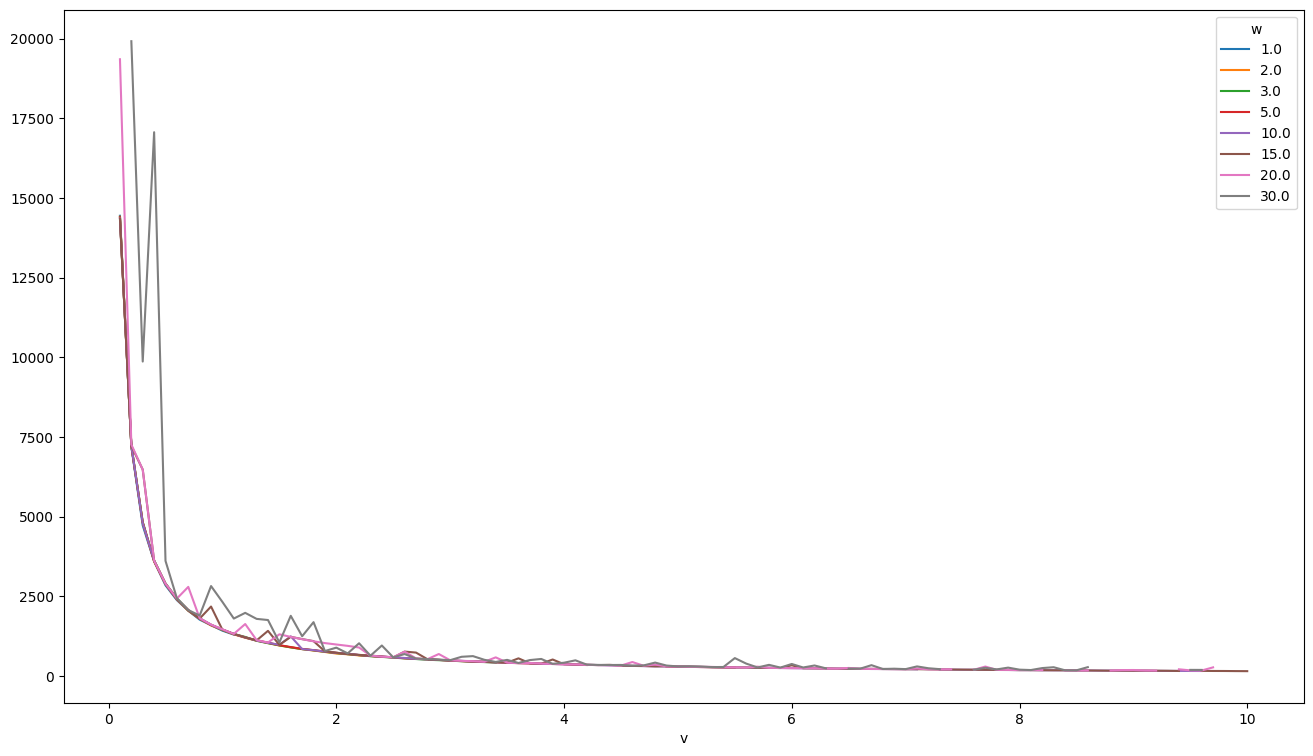

In [13]:
df_to_plot_t.plot(figsize=(16, 9))

<AxesSubplot: xlabel='v'>

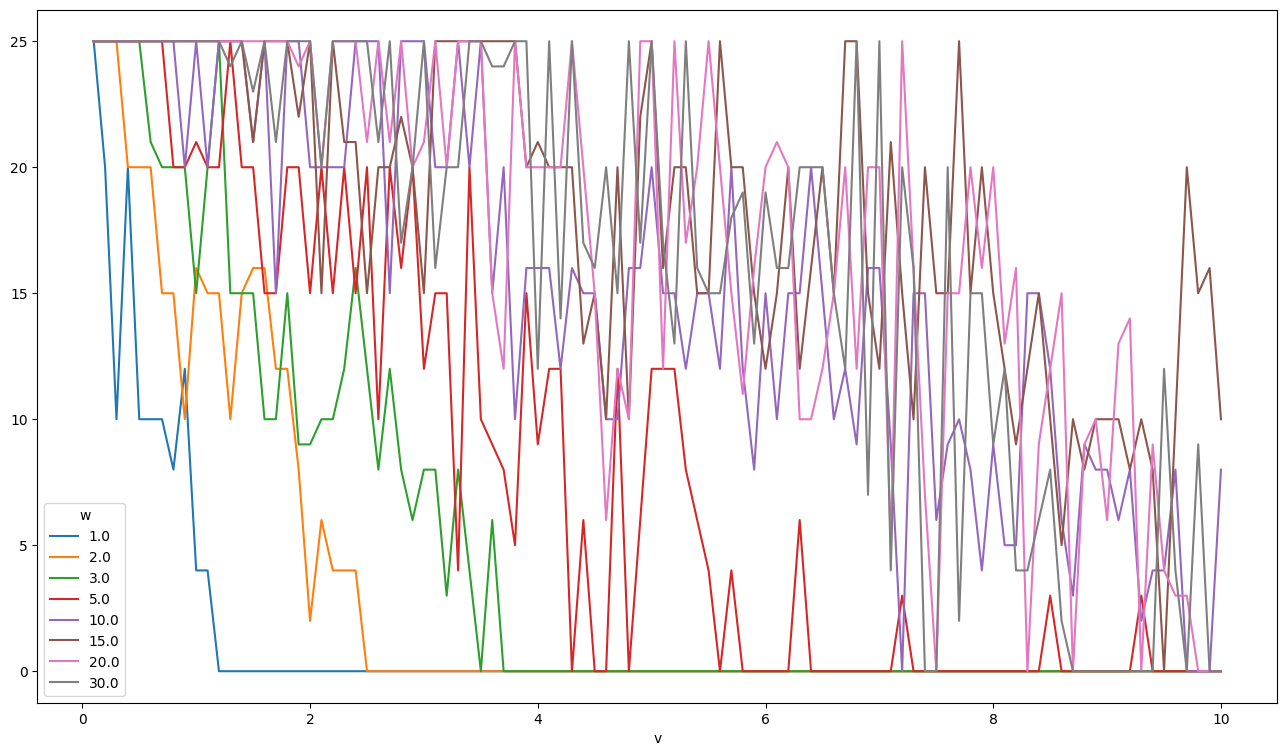

In [14]:
df_to_plot_s.plot(figsize=(16, 9))


In [17]:
def plot_t_for_angle(w:float, ax:Axes):
    ax.plot(df_to_plot_t.index, df_to_plot_t[w])
    ax.set_title(f'Steps of reaching goal position. w={w}')

def plot_s_for_angle(w:float, ax:Axes):
    ax.plot(df_to_plot_s.index, df_to_plot_s[w])
    ax.set_yticks([*range(26)])
    ax.yaxis.grid(True)
    ax.set_title(f'Alive agent counts. w={w}')

In [18]:
ax.clear()
for w in W:
    plot_s_for_angle(w, ax)
    fig.savefig(os.path.join(dir_name, 'plot_alive_agent_count_'+'W='+str(w)+'.jpg'), bbox_inches='tight')
    ax.clear()

In [19]:
ax.clear()
for w in W:
    plot_t_for_angle(w, ax)
    fig.savefig(os.path.join(dir_name, 'plot_step_count_count_'+'W='+str(w)+'.jpg'), bbox_inches='tight')
    ax.clear()